## Transfer Learning

In [ ]:
from src.helpers import setup_env

# Download dataset
setup_env()

GPU available
done


Computing std: 100%|████████████████████████| 6246/6246 [02:00<00:00, 51.94it/s]


In [ ]:
from transformers import ViTForImageClassification, ViTConfig, AutoImageProcessor
from torch import nn

class CustomViTClassifier(ViTForImageClassification):
    def __init__(self, config, dropout_rate=0.1):
        super().__init__(config)
        self.dropout = nn.Dropout(dropout_rate)

        pretrained_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
        self.vit = pretrained_model.vit
        # Replace the classifier with your custom head
        self.classifier = nn.Linear(config.hidden_size, 50)
        # Freeze ViT layers (optional)
        for param in self.parameters():
            param.requires_grad = False
        for param in self.classifier.parameters():
          param.requires_grad = True

    def forward(self, pixel_values, labels=None):
        outputs = self.vit(pixel_values)
        x = outputs.last_hidden_state[:, 0]
        x = self.dropout(x)
        logits = self.classifier(x)
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return {"loss": loss, "logits": logits}
        return logits

    def fine_tune(self):
        for param in self.parameters():
            param.requires_grad = True
# Initialize your custom model
config = ViTConfig.from_pretrained("google/vit-base-patch16-224")
config.num_labels = 50  # Match your custom classifier
model = CustomViTClassifier(config, dropout_rate=0.3)
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),  # If vertical symmetry is possible
    transforms.RandomRotation(degrees=15),
    transforms.RandomPerspective(
        distortion_scale=0.4,  # Stronger perspective warping
        p=0.3
    ),
    transforms.RandomAffine(
        degrees=0,
        shear=15,  # Shear in both axes
        scale=(0.8, 1.2)  # Additional scaling variation
    ),

    # Photometric transforms
    transforms.RandAugment(
        num_ops=3,  # Increased from 2 to 3 operations
        magnitude=15,
        num_magnitude_bins=31,
        interpolation=transforms.InterpolationMode.BICUBIC
    ),
    transforms.ColorJitter(
        brightness=0.4,  # Slightly increased
        contrast=0.4,
        saturation=0.3,
        hue=0.025
    ),
    transforms.GaussianBlur(
        kernel_size=5,
        sigma=(0.1, 3.0)  # Stronger blur variations
    ),
    transforms.RandomGrayscale(p=0.15),  # Increased grayscale probability
    transforms.RandomSolarize(
        threshold=175,  # More aggressive solarization
        p=0.1
    ),

    # Spatial regularization
    transforms.RandomErasing(
        p=0.6,  # Significantly increased probability
        scale=(0.05, 0.35),  # Larger masking areas
        ratio=(0.2, 4.0),  # Wider aspect ratios
        value='random'
    ),
    transforms.RandomErasing(  # Secondary erasing layer
        p=0.4,
        scale=(0.02, 0.2),
        ratio=(0.1, 6),
        value='random'
    )])

# Create augmented preprocess function
def preprocess_function_with_aug(examples):
    # Process all images in the batch with augmentation
    inputs = processor(
        examples['image'],
        do_resize=True,
        do_normalize=True,
        return_tensors="pt",
        image_transform=train_transform  # Apply augmentation during processing
    )
    inputs['labels'] = examples['label']
    return inputs

# Create preprocess function
def preprocess_function(examples):
    # Process all images in the batch
    inputs = processor(
        examples['image'],
        do_resize=True,
        do_normalize=True,
        return_tensors="pt"
    )
    # Add labels
    inputs['labels'] = examples['label']
    return inputs

In [ ]:
!pip install -q datasets evaluate

In [ ]:
from datasets import load_dataset

# Load the datasets
train_val_dataset = load_dataset('imagefolder', data_dir='landmark_images/train', split='train')
test_dataset = load_dataset('imagefolder', data_dir='landmark_images/test', split='train')

# Split train dataset into train and validation
train_val_split = train_val_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_val_split['train']
eval_dataset = train_val_split['test']

# Apply preprocessing to all datasets
train_dataset = train_dataset.with_transform(preprocess_function_with_aug)
eval_dataset = eval_dataset.with_transform(preprocess_function)
test_dataset = test_dataset.with_transform(preprocess_function)

In [ ]:
import evaluate
import numpy as np

accuracy = evaluate.load('accuracy')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
        output_dir='./results',
        remove_unused_columns=False,
        logging_strategy='epoch',
        evaluation_strategy='epoch',
        save_strategy='epoch',
        learning_rate=1e-3,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=20,
        load_best_model_at_end=True,
        greater_is_better=True,
    )

trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        processing_class=processor,
        compute_metrics=compute_metrics,
    )

    # Train model
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: bsvaz (bsvaz17). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'image_transform'
  return self.preprocess(images, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.656100,0.777349,0.814000
2,0.617500,0.621195,0.841000
3,0.417500,0.542927,0.864000
4,0.299400,0.515930,0.864000
5,0.230300,0.493998,0.868000
6,0.180800,0.483937,0.876000
7,0.143500,0.482992,0.867000
8,0.128800,0.482338,0.874000
9,0.107600,0.480960,0.875000
10,0.091000,0.483614,0.874000


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'image_transform'
  return self.preprocess(images, **kwargs)
/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'image_transform'
  return self.preprocess(images, **kwargs)
/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'image_transform'
  return self.preprocess(images, **kwargs)
/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'image_transform'
  return self.preprocess(im

TrainOutput(global_step=2500, training_loss=0.22525808868408204, metrics={'train_runtime': 2262.7379, 'train_samples_per_second': 35.32, 'train_steps_per_second': 1.105, 'total_flos': 6.195824161956495e+18, 'train_loss': 0.22525808868408204, 'epoch': 20.0})

In [ ]:
model.save_pretrained('landmark-classification-vit')
processor.save_pretrained('landmark-classification-vit')

['landmark-classification-vit/preprocessor_config.json']

## Fine Tuning

In [ ]:
from src.helpers import setup_env

# Download dataset
setup_env()

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),  # If vertical symmetry is possible
    transforms.RandomRotation(degrees=15),
    transforms.RandomPerspective(
        distortion_scale=0.4,  # Stronger perspective warping
        p=0.3
    ),
    transforms.RandomAffine(
        degrees=0,
        shear=15,  # Shear in both axes
        scale=(0.8, 1.2)  # Additional scaling variation
    ),

    # Photometric transforms
    transforms.RandAugment(
        num_ops=3,  # Increased from 2 to 3 operations
        magnitude=15,
        num_magnitude_bins=31,
        interpolation=transforms.InterpolationMode.BICUBIC
    ),
    transforms.ColorJitter(
        brightness=0.4,  # Slightly increased
        contrast=0.4,
        saturation=0.3,
        hue=0.025
    ),
    transforms.GaussianBlur(
        kernel_size=5,
        sigma=(0.1, 3.0)  # Stronger blur variations
    ),
    transforms.RandomGrayscale(p=0.15),  # Increased grayscale probability
    transforms.RandomSolarize(
        threshold=175,  # More aggressive solarization
        p=0.1
    ),

    # Spatial regularization
    transforms.RandomErasing(
        p=0.6,  # Significantly increased probability
        scale=(0.05, 0.35),  # Larger masking areas
        ratio=(0.2, 4.0),  # Wider aspect ratios
        value='random'
    ),
    transforms.RandomErasing(  # Secondary erasing layer
        p=0.4,
        scale=(0.02, 0.2),
        ratio=(0.1, 6),
        value='random'
    )])

# Create augmented preprocess function
def preprocess_function_with_aug(examples):
    # Process all images in the batch with augmentation
    inputs = processor(
        examples['image'],
        do_resize=True,
        do_normalize=True,
        return_tensors="pt",
        image_transform=train_transform  # Apply augmentation during processing
    )
    inputs['labels'] = examples['label']
    return inputs

# Create preprocess function
def preprocess_function(examples):
    # Process all images in the batch
    inputs = processor(
        examples['image'],
        do_resize=True,
        do_normalize=True,
        return_tensors="pt"
    )
    # Add labels
    inputs['labels'] = examples['label']
    return inputs

In [ ]:
from datasets import load_dataset

# Load the datasets
train_val_dataset = load_dataset('imagefolder', data_dir='landmark_images/train', split='train')
test_dataset = load_dataset('imagefolder', data_dir='landmark_images/test', split='train')

# Split train dataset into train and validation
train_val_split = train_val_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_val_split['train']
eval_dataset = train_val_split['test']

# Apply preprocessing to all datasets
train_dataset = train_dataset.with_transform(preprocess_function_with_aug)
eval_dataset = eval_dataset.with_transform(preprocess_function)
test_dataset = test_dataset.with_transform(preprocess_function)

Resolving data files:   0%|          | 0/4996 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/1250 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

model = AutoModelForImageClassification.from_pretrained('landmark-classification-vit')
processor = AutoImageProcessor.from_pretrained('landmark-classification-vit')

In [ ]:
!pip install -q datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import evaluate
import numpy as np

accuracy = evaluate.load('accuracy')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
        output_dir='./results',
        remove_unused_columns=False,
        logging_strategy='epoch',
        evaluation_strategy='epoch',
        save_strategy='epoch',
        learning_rate=1e-4,
        weight_decay=0.6,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        load_best_model_at_end=True,
        greater_is_better=True,
    )

trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        processing_class=processor,
        compute_metrics=compute_metrics,
    )

    # Train model
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'image_transform'
  return self.preprocess(images, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.537700,0.485004,0.876000
2,0.102300,0.421713,0.889000
3,0.015600,0.393263,0.892000
4,0.003500,0.366688,0.902000
5,0.002100,0.356011,0.904000
6,0.001600,0.354568,0.903000
7,0.001300,0.354737,0.901000
8,0.001200,0.354390,0.900000
9,0.001100,0.354481,0.900000
10,0.001100,0.354556,0.900000


/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'image_transform'
  return self.preprocess(images, **kwargs)
/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'image_transform'
  return self.preprocess(images, **kwargs)
/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'image_transform'
  return self.preprocess(images, **kwargs)
/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'image_transform'
  return self.preprocess(im

TrainOutput(global_step=1250, training_loss=0.06674902094602585, metrics={'train_runtime': 1936.5727, 'train_samples_per_second': 20.634, 'train_steps_per_second': 0.645, 'total_flos': 3.0979120809782477e+18, 'train_loss': 0.06674902094602585, 'epoch': 10.0})

In [ ]:
model.save_pretrained('landmark-classification-vit')
processor.save_pretrained('landmark-classification-vit')

['landmark-classification-vit/preprocessor_config.json']

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model.push_to_hub('landmark-classification-vit',
                  commit_message='Add Vision Transformer for landmark classification',
                  use_auth_token=True)

processor.push_to_hub('landmark-classification-vit',
                      commit_message='Add image processor config',
                      use_auth_token=True)

/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:894: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/bsvaz/landmark-classification-vit/commit/75d48d6e2f382fb49f3f6b172bbdacdd5ffb208d', commit_message='Add image processor config', commit_description='', oid='75d48d6e2f382fb49f3f6b172bbdacdd5ffb208d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bsvaz/landmark-classification-vit', endpoint='https://huggingface.co', repo_type='model', repo_id='bsvaz/landmark-classification-vit'), pr_revision=None, pr_num=None)

## Evaluation

In [1]:
from src.helpers import setup_env

# Download dataset
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


/content/src/helpers.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(cache_file)


In [2]:
from transformers import pipeline

classifier = pipeline(
    'image-classification',
    model='bsvaz/landmark-classification-vit',
    function_to_apply='softmax'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [3]:
!pip install -q evaluate datasets

In [4]:
from datasets import load_dataset
test_dataset = load_dataset('imagefolder', data_dir='landmark_images/test', split='train', num_proc=2)

Resolving data files:   0%|          | 0/1250 [00:00<?, ?it/s]

In [5]:
def classify_batch(batch, classifier):
    """
    Processes a batch of dataset items, performs image classification,
    and appends a "prediction" field containing the predicted numeric label.

    Each item in the batch should have:
      - "image": the image (e.g., a PIL image)
      - "label": the true numeric label
    """
    # Retrieve mapping from the classifier's configuration.
    id2label = classifier.model.config.id2label
    label2id = {label: int(idx) for idx, label in id2label.items()}

    images = batch["image"]
    preds = classifier(images)

    pred_ids = []
    for pred in preds:
        # If the prediction is a list (e.g., because top_k > 1), take the first element.
        if isinstance(pred, list):
            pred = pred[0]
        label_str = pred['label']
        pred_id = label2id.get(label_str)
        # Fallback: if not found, attempt to parse a numeric id from the label string.
        if pred_id is None and label_str.startswith("LABEL_"):
            pred_id = int(label_str.split("LABEL_")[-1])
        pred_ids.append(pred_id)

    batch["prediction"] = pred_ids
    return batch


In [6]:
# Use the .map() method to process the dataset in batches.
result_dataset = test_dataset.map(classify_batch, batched=True, batch_size=32, fn_kwargs={"classifier": classifier})

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [7]:
import evaluate

# Load evaluation metrics.
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

In [8]:
import numpy as np

# Extract predictions and true labels.
predictions = np.array(result_dataset["prediction"])
labels = np.array(result_dataset["label"])

# Compute evaluation metrics.
accuracy_result = accuracy.compute(predictions=predictions, references=labels)
precision_result_micro = precision.compute(predictions=predictions, references=labels, average="micro")
precision_result_macro = precision.compute(predictions=predictions, references=labels, average="macro")
recall_result_micro = recall.compute(predictions=predictions, references=labels, average="micro")
recall_result_macro = recall.compute(predictions=predictions, references=labels, average="macro")
f1_result_micro = f1.compute(predictions=predictions, references=labels, average="micro")
f1_result_macro = f1.compute(predictions=predictions, references=labels, average="macro")

In [9]:
print("Accuracy:", accuracy_result)
print("Precision (micro):", precision_result_micro)
print("Precision (macro):", precision_result_macro)
print("Recall (micro):", recall_result_micro)
print("Recall (macro):", recall_result_macro)
print("F1 Score (micro):", f1_result_micro)
print("F1 Score (macro):", f1_result_macro)

Accuracy: {'accuracy': 0.8984}
Precision (micro): {'precision': 0.8984}
Precision (macro): {'precision': 0.9060373079728875}
Recall (micro): {'recall': 0.8984}
Recall (macro): {'recall': 0.8984000000000001}
F1 Score (micro): {'f1': 0.8984}
F1 Score (macro): {'f1': 0.8993639098392765}


In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import re  # For string processing

def clean_label(label):
    """Cleans up the label by removing numeric prefixes and replacing underscores with spaces."""
    return re.sub(r"^\d+\.", "", label).replace("_", " ").strip()

def visualize_predictions(test_dataset, classifier, n=5, k=5):
    # Custom styling parameters
    FIGURE_WIDTH = 14
    TITLE_FONT = {'fontsize': 14, 'fontweight': 'bold', 'fontfamily': 'sans-serif', 'color': '#4B0082'}  # Dark Purple
    LABEL_FONT = {'fontsize': 10, 'fontfamily': 'sans-serif', 'color': '#333333'}
    BAR_COLORS = plt.cm.Purples(np.linspace(0.4, 0.9, k))[::-1]  # Purple gradient
    EDGE_COLOR = '#E3A857'  # Light orange for contrast
    PLOT_BG = '#FAF3E0'  # Softer beige background

    # Create figure with better spacing
    fig, axes = plt.subplots(n, 2, figsize=(FIGURE_WIDTH, 2.5 * n),
                             gridspec_kw={'wspace': 0.5, 'hspace': 0.7})
    fig.patch.set_facecolor(PLOT_BG)

    # Select random indices
    indices = np.random.choice(len(test_dataset), size=n, replace=False)

    for row, idx in enumerate(indices):
        # Get data
        example = test_dataset[int(idx)]
        image = example['image']
        true_label = clean_label(test_dataset.features['label'].names[example['label']])

        # Get predictions
        predictions = classifier(image)
        top_k = sorted(predictions, key=lambda x: x['score'], reverse=True)[:k]
        labels = [clean_label(p['label']) for p in top_k]  # Apply label cleaning
        scores = [p['score'] for p in top_k]

        # --- Image Plot ---
        ax_img = axes[row, 0]
        ax_img.imshow(image)
        ax_img.set_title(f"Actual: {true_label}\nPredicted: {labels[0]} ({scores[0]:.1%})",
                         pad=12, **TITLE_FONT)
        ax_img.axis('off')

        # Add frame around image
        for spine in ax_img.spines.values():
            spine.set_visible(True)
            spine.set_color(EDGE_COLOR)
            spine.set_linewidth(1.5)

        # --- Bar Chart ---
        ax_bar = axes[row, 1]
        y_pos = np.arange(len(labels))

        # Create horizontal bars with better spacing
        bars = ax_bar.barh(y_pos, scores[::-1], color=[0.71372549, 0.71372549, 0.84705882, 1.        ], height=0.6,
                           edgecolor='white', linewidth=1)

        # Add value annotations
        for bar in bars:
            width = bar.get_width()
            ax_bar.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                        f'{width:.1%}', va='center', fontsize=9,
                        fontweight='bold', color='#4B0082')  # Dark Purple text

        # Format y-axis labels
        ax_bar.set_yticks(y_pos)
        ax_bar.set_yticklabels(labels[::-1], **LABEL_FONT)
        ax_bar.set_xlim(0, 1)
        ax_bar.xaxis.set_major_formatter(ticker.PercentFormatter(1.0))

        # Improve bar chart aesthetics
        ax_bar.spines['top'].set_visible(False)
        ax_bar.spines['right'].set_visible(False)
        ax_bar.spines['bottom'].set_color('#BEBEBE')
        ax_bar.spines['left'].set_color('#BEBEBE')
        ax_bar.set_xlabel("Probability", labelpad=10, color='#4B0082', fontsize=11)
        ax_bar.grid(axis='x', linestyle='dashed', alpha=0.5)
        ax_bar.set_title("Top-5 Predictions", fontsize=11, fontweight='bold', color='#4B0082', pad=10)

    plt.show()


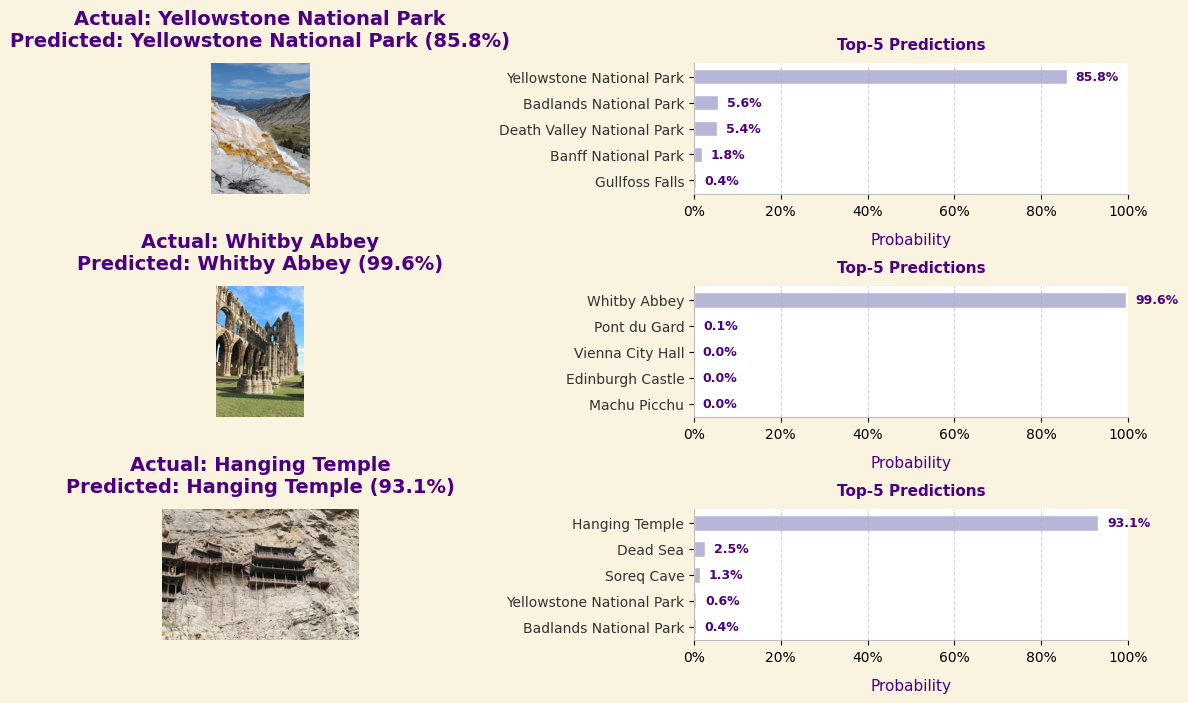

In [42]:
visualize_predictions(test_dataset, classifier, n=3, k=5)